# Exploratory Analysis

This notebook contains steps and decisions made in the second iteration of exploring the Austin crime data.

## The Required Imports

Here we'll import all the modules required to run the code cells in this notebook.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

from wrangle import wrangle_crime_data
from prepare import split_data
from explore import *

## Acquire and Prepare Data

Here we'll acquire and prepare the data using the wrangle module.

In [2]:
# We'll need to explictly drop all cleared by exception rows.

df = wrangle_crime_data(drop_cleared_by_exception = True)
df.shape

Using cached csv


(348008, 18)

## Split the Data

Now we will need to split the data before we begin exploring because we will now begin exploring the relationship between the target variable and other features in the data.

In [3]:
train, validate, test = split_data(df, 'cleared')
train.shape, validate.shape, test.shape

((194884, 18), (83522, 18), (69602, 18))

From here on we'll only use the train variable.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194884 entries, 229881 to 160882
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        194884 non-null  object         
 1   family_violence   194884 non-null  object         
 2   occurrence_time   194884 non-null  datetime64[ns] 
 3   occurrence_date   194884 non-null  datetime64[ns] 
 4   report_time       194884 non-null  datetime64[ns] 
 5   report_date       194884 non-null  datetime64[ns] 
 6   location_type     194884 non-null  object         
 7   address           194884 non-null  object         
 8   zip_code          194884 non-null  float64        
 9   council_district  194884 non-null  float64        
 10  sector            194884 non-null  object         
 11  district          194884 non-null  object         
 12  latitude          194884 non-null  float64        
 13  longitude         194884 non-null  floa

## At what response time does clearance rate drop off significantly?

In [13]:
# Here we'll look at the difference in clearance rate between observations with time_to_report less than n hours and 
# observations with time_to_report greater than n hours where n is in the range 0 - 24 hours.

for hour in range(25):
    print(
        f'{hour}: ',
        train[train.time_to_report <= pd.Timedelta(f'{hour}h')].cleared.mean(),
        train[train.time_to_report > pd.Timedelta(f'{hour}h')].cleared.mean()
    )

0:  0.3509714453929938 0.10539362715692156
1:  0.33284584328911593 0.08429459647400499
2:  0.32938568181180367 0.0608058191737228
3:  0.32674163685906255 0.04558667915394626
4:  0.32377042139801754 0.03653998113736586
5:  0.3201273821127281 0.032449388443694646
6:  0.3169163287263097 0.030626299727226077
7:  0.3137658602743531 0.029757059886600355
8:  0.3109066528805454 0.029146972766149
9:  0.30757875586479844 0.028953421506612995
10:  0.30445753396573066 0.028649085433041944
11:  0.30099415341258534 0.028570138334863698
12:  0.29720853858784896 0.02830013321354441
13:  0.2930230100253654 0.027971803909003525
14:  0.28906511285683495 0.027629986906005006
15:  0.28488053184720363 0.027668392000412705
16:  0.280996139885925 0.027539801527807526
17:  0.2776389401641439 0.02692848682262363
18:  0.2747030862206767 0.026392344497607655
19:  0.2721166709410892 0.025743356712437025
20:  0.26983113673805603 0.02544508576538493
21:  0.267682574237219 0.025329407588381467
22:  0.2659232659232659

In [18]:
# Now let's put these results in a line chart.

clearance_rates = [train[train.time_to_report <= pd.Timedelta(f'{hour}h')].cleared.mean() for hour in range(7 * 24 + 1)]

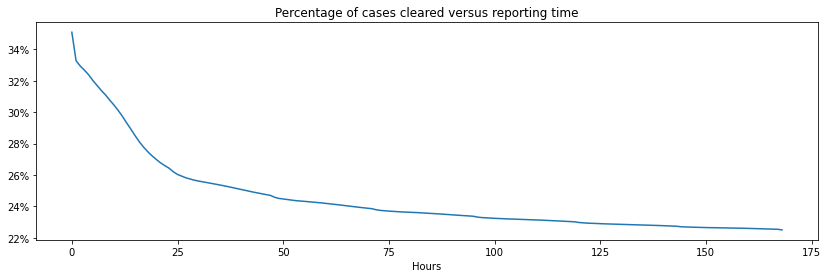

In [33]:
plt.figure(figsize = (14, 4))
temp = pd.DataFrame({'clearance_rate' : clearance_rates})

ax = sns.lineplot(data = temp, y = 'clearance_rate', x = temp.index)

plt.xlabel('Hours')
plt.ylabel('')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0))

plt.title('Percentage of cases cleared versus reporting time');

In [34]:
train['time_to_report_bins'] = pd.cut(
    train.time_to_report,
    [
        pd.Timedelta('-1d'),
        pd.Timedelta('24h'),
        pd.Timedelta('10y')
    ],
    labels = [
        'Less than 24 hours',
        'Greater than 24 hours'
    ]
)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


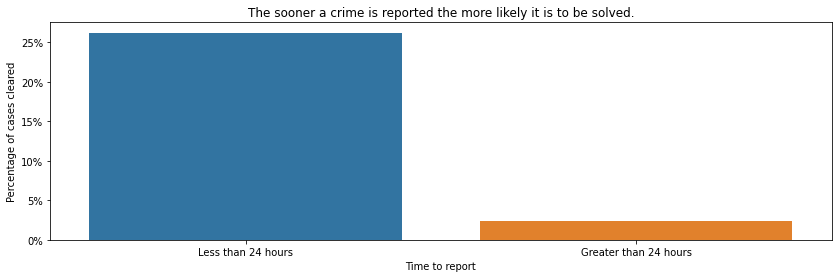

In [38]:
plt.figure(figsize = (14, 4))

ax = sns.barplot(
    data = train,
    x = 'time_to_report_bins',
    y = 'cleared',
    ci = None
)

plt.xlabel('Time to report')
plt.ylabel('Percentage of cases cleared')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0))

plt.title('The sooner a crime is reported the more likely it is to be solved.');

## How does type of crime affect the dependency between clearance status and time to report?

I'm interested to know for which crime types is there no significant difference in clearance rate between crimes with a report time less than 24 hours and crimes with a report time greater than 24 hours.

In [71]:
# Here we're going to run a t-test for each crime type testing the following hypothesis:
# H0: The average number of cases cleared for cases with time to report less than 24 hours is equal 
# to the average number of cases cleared for cases with time to report greater than 24 hours.

# We'll keep a list of all crime types where p is not less than alpha meaning the null hypothesis could not 
# be rejected.
# We'll only look at crime types with at least 30 observations and assume non equal variance for simplicity.

alpha = 0.05
types = []

time_to_report_less_than_24hrs = train.time_to_report <= pd.Timedelta('24h')
time_to_report_greater_than_24hrs = train.time_to_report > pd.Timedelta('24h')

for crime in train.crime_type.unique():
    subset = train[train.crime_type == crime]
    
    if train[train.crime_type == crime].cleared.count() > 100 and train[train.crime_type == crime].cleared.mean() < 0.5:
        t, p = stats.ttest_ind(
            subset[time_to_report_less_than_24hrs].cleared,
            subset[time_to_report_greater_than_24hrs].cleared,
            alternative = 'greater',
            equal_var = False
        )
        if p >= alpha:
            types.append(crime)

/var/folders/45/z3vf0vrn1fz5mzs6sp418wym0000gn/T/ipykernel_1808/3647183039.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset[time_to_report_less_than_24hrs].cleared,
/var/folders/45/z3vf0vrn1fz5mzs6sp418wym0000gn/T/ipykernel_1808/3647183039.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset[time_to_report_greater_than_24hrs].cleared,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [72]:
len(types)

22

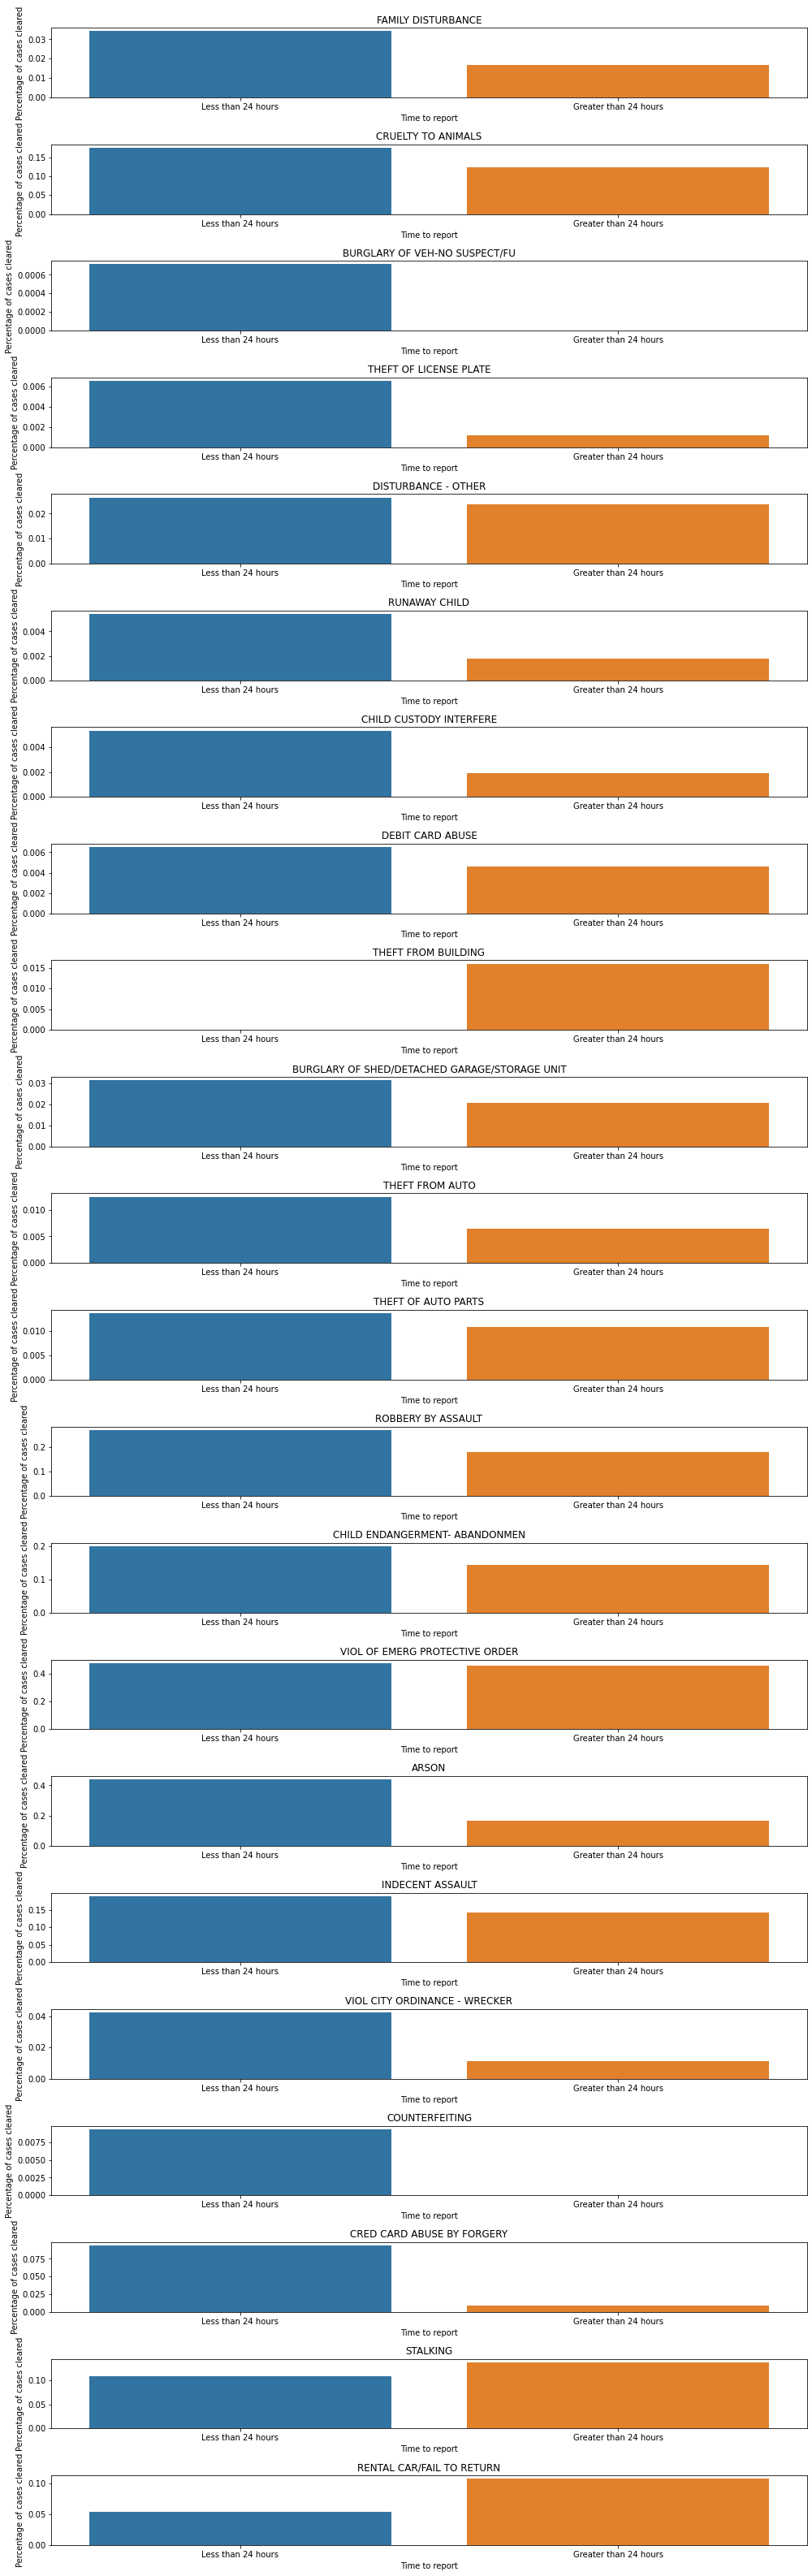

In [73]:
fig, ax = plt.subplots(nrows = len(types), ncols = 1, figsize = (14, 2 * len(types)))

for index, crime_type in enumerate(types):
    sns.barplot(
        data = train[train.crime_type == crime_type],
        x = 'time_to_report_bins',
        y = 'cleared',
        ci = None,
        ax = ax[index]
    )

    ax[index].set_xlabel('Time to report')
    ax[index].set_ylabel('Percentage of cases cleared')

    ax[index].set_title(crime_type)
    
plt.tight_layout();

In [74]:
sorted(types)

['ARSON',
 'BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT',
 'BURGLARY OF VEH-NO SUSPECT/FU',
 'CHILD CUSTODY INTERFERE',
 'CHILD ENDANGERMENT- ABANDONMEN',
 'COUNTERFEITING',
 'CRED CARD ABUSE BY FORGERY',
 'CRUELTY TO ANIMALS',
 'DEBIT CARD ABUSE',
 'DISTURBANCE - OTHER',
 'FAMILY DISTURBANCE',
 'INDECENT ASSAULT',
 'RENTAL CAR/FAIL TO RETURN',
 'ROBBERY BY ASSAULT',
 'RUNAWAY CHILD',
 'STALKING',
 'THEFT FROM AUTO',
 'THEFT FROM BUILDING',
 'THEFT OF AUTO PARTS',
 'THEFT OF LICENSE PLATE',
 'VIOL CITY ORDINANCE - WRECKER',
 'VIOL OF EMERG PROTECTIVE ORDER']

### Takeaways

This list of crime types are all crimes with at least 100 observations where the reporting time does not make a significant difference in clearance rate. There are a few ways to interpret this. These can either be crimes that are generally unsolvable, or at least unclearable. Otherwise, we can look at these crimes as areas of improvement since reporting time doesn't seem to make a difference in the solvability of these crimes.

## Clearance Date

In [100]:
train[train.cleared == False].head()

,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,time_to_report_bins
229881,FAMILY DISTURBANCE,N,2019-12-27 23:14:00,2019-12-27,2019-12-27 23:14:00,2019-12-27,RESIDENCE / HOME,5800 TECHNI CENTER DR,78721.0,1.0,CH,5,30.278777,-97.671951,not cleared,2020-01-08,False,0 days 00:00:00,Less than 24 hours
131423,ASSAULT W/INJURY-FAM/DATE VIOL,Y,2020-12-17 21:18:00,2020-12-17,2020-12-17 21:18:00,2020-12-17,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,8601 RESEARCH BLVD SVRD NB,78758.0,4.0,ED,2,30.362560,-97.715688,not cleared,2020-12-21,False,0 days 00:00:00,Less than 24 hours
362058,CRUELTY TO ANIMALS,N,2018-09-26 13:17:00,2018-09-26,2018-09-26 13:17:00,2018-09-26,RESIDENCE / HOME,2312 RACHAEL CT,78748.0,5.0,FR,1,30.177874,-97.828377,not cleared,2018-09-27,False,0 days 00:00:00,Less than 24 hours
343230,AGG ASSAULT FAM/DATE VIOLENCE,Y,2018-12-01 19:31:00,2018-12-01,2018-12-01 19:31:00,2018-12-01,RESIDENCE / HOME,4810 SINGLE SHOT CIR,78723.0,1.0,CH,4,30.291001,-97.676904,not cleared,2018-12-06,False,0 days 00:00:00,Less than 24 hours
145220,BURGLARY OF VEH-NO SUSPECT/FU,N,2020-10-30 15:30:00,2020-10-30,2020-10-30 16:57:00,2020-10-30,RESIDENCE / HOME,1600 MUSKET VALLEY TRL,78754.0,1.0,ED,5,30.374472,-97.655692,not cleared,2020-11-02,False,0 days 01:27:00,Less than 24 hours


Even for crimes that are not cleared there is a clearance date. This would definitely require more context to understand.

## Multivariate Analysis With Crime Types

Let's look at how the crime types vary with different variables.